### Overview
- This notebook shows an example of AutoEncoder and Variational AutoEncoder (VAE) 
- These are the following steps:   
    1. We load the dataset (MNIST here)
    2. We define a Convolutional AutoEncoder, Train it & Generate images from it.
    3. We define a Convolutional VAE, Train it & Generate images from it.
    4. We define a Linear VAE AutoEncoder, Train it & Generate images from it.
- Environment:
    - conda env create -f environment_mlenv7.yml
    - conda activate mlenv7


In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [2]:
# Warning control
import warnings
warnings.filterwarnings('ignore')

In [3]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm

from torchvision.utils import save_image, make_grid

from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
import torch.nn.functional as F

import matplotlib.pyplot as plt
import random


### 1. Load dataset

Example image:


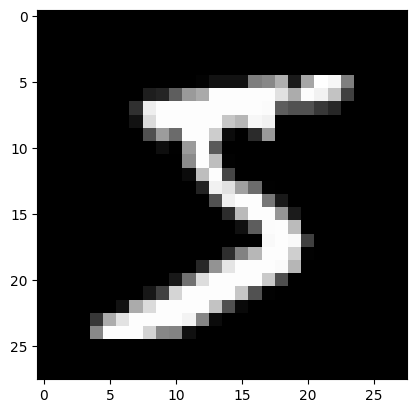

In [4]:
dataset_path = './datasets'
mnist_transform = transforms.Compose([
        transforms.ToTensor(),
])
train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset  = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)

print('Example image:')
plt.imshow(train_dataset[0][0].squeeze(), cmap='gray')

In [5]:
# Model Hyperparameters
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

batch_size = 128
x_dim  = 784
hidden_dim = 512
latent_dim = 256
lr = 1e-3
epochs = 30

In [6]:
kwargs = {'num_workers': 1, 'pin_memory': True} # {'drop_last': True}
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False, **kwargs)

### 2. Define & Train AutoEncoder (Convolutional)

In [7]:
class ConvAE(nn.Module):
    
    def __init__(self, hdim=20):
        super(ConvAE, self).__init__()
        # Encoder layers
        self.enc_conv1 = nn.Conv2d(1, 32, 3)
        self.enc_conv2 = nn.Conv2d(32, 32, 3)
        self.enc_fc1 = nn.Linear(32*24*24, 128)
        self.enc_fc2 = nn.Linear(128, hdim)

        # Decoder layers
        self.dec_fc1 = nn.Linear(hdim, 128)
        self.dec_fc2 = nn.Linear(128, 32*24*24)
        self.dec_unflatten = nn.Unflatten(dim=-1, unflattened_size=(32, 24, 24))
        self.dec_conv1 = nn.ConvTranspose2d(32, 32, 3)
        self.dec_conv2 = nn.ConvTranspose2d(32, 1, 3)

    def encoder(self, x):
        x = self.enc_conv1(x)
        x = F.relu(x)
        x = self.enc_conv2(x)
        x = F.relu(x)
        x = torch.flatten(x, 1)
        x = self.enc_fc1(x)
        x = F.relu(x)
        x = self.enc_fc2(x)
        return x

    def decoder(self, x):
        x = self.dec_fc1(x)
        x = F.relu(x)
        x = self.dec_fc2(x)
        x = F.relu(x)
        x = self.dec_unflatten(x)
        x = self.dec_conv1(x)
        x = F.relu(x)
        x = self.dec_conv2(x)
        return torch.sigmoid(x) # Sigmoid means the output must be between 0 and 1 (you can explore removing this)

    def forward(self, x):
        return self.decoder(self.encoder(x))

# Instantiate the model
ae = ConvAE()

Input shape: torch.Size([1, 1, 28, 28])
Encoded shape: torch.Size([1, 20])
Decoded shape: torch.Size([1, 1, 28, 28])
Decoded image:


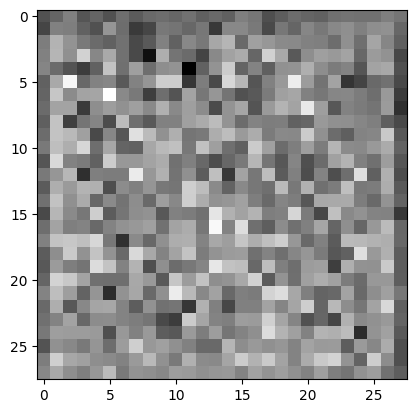

In [8]:
# Example before training 
x = train_dataset[0][0].unsqueeze(0)
print('Input shape:', x.shape)
encoded = ae.encoder(x)
print('Encoded shape:', encoded.shape)
decoded = ae.decoder(encoded)
print('Decoded shape:', decoded.shape)
print('Decoded image:')
plt.imshow(decoded.detach().squeeze(), cmap='gray')

In [9]:
# Train
ae.to(device)
optimizer = Adam(ae.parameters(),lr=1e-3,weight_decay=1e-5)
loss_fn = nn.MSELoss()
for epoch in range(2):
    for im_batch, _ in tqdm(train_loader):
        im_batch = im_batch.to(device)
        optimizer.zero_grad()
        reconstruction = ae(im_batch) # The forward method encodes and then decodes
        loss = loss_fn(reconstruction.view(batch_size, -1),
                       target=im_batch.view(batch_size, -1))
        loss.backward()
        optimizer.step()

100%|██████████| 469/469 [00:14<00:00, 32.91it/s]


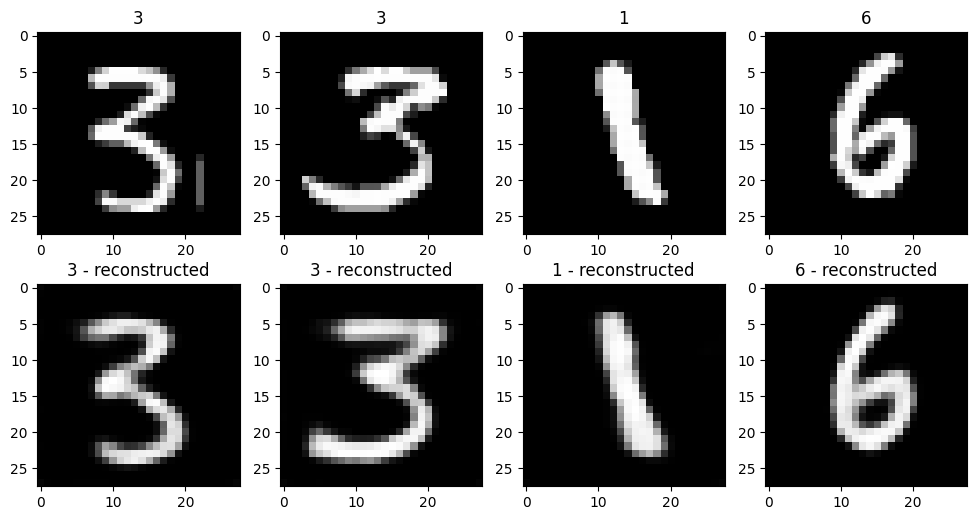

In [10]:
# Plot the reconstructed versions of some random samples 
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
for i in range(4):
    im, label = test_dataset[random.randint(0, len(test_dataset))]
    axs[0][i].imshow(im.squeeze(), cmap='gray')
    axs[0][i].set_title(label)
    axs[1][i].imshow(ae(im.unsqueeze(0).to(device)).squeeze().detach().cpu(), cmap='gray')
    axs[1][i].set_title(str(label) + ' - reconstructed')

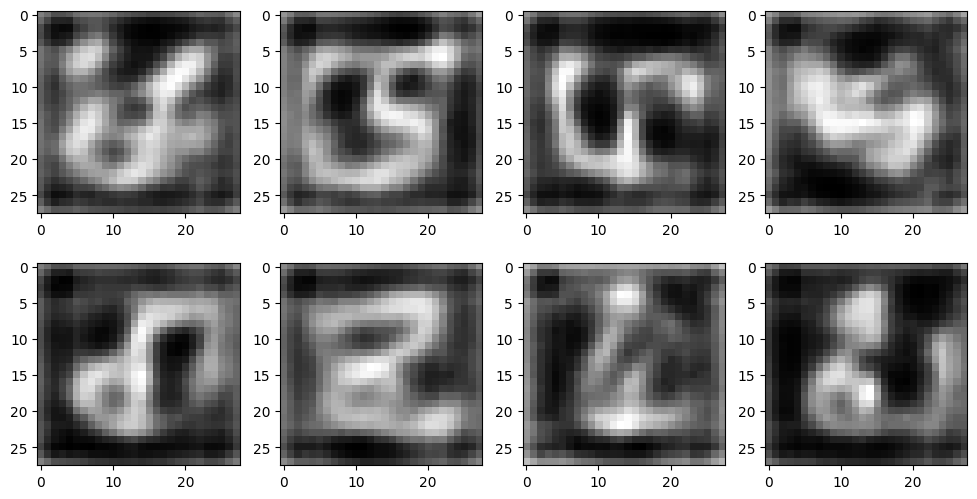

In [11]:
# Generate new images from random z
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
for i in range(8):
    im = ae.decoder(torch.randn(1, 20).to(device)) # latent dim is 20 here.
    axs[i//4][i%4].imshow(im.detach().cpu().squeeze(), cmap='gray')

##### Note:
- As seen, Autoencoder has not been trained to learn a latent space to generate new images from random noise vectors. 

### 3. Define & Train VAE - Convolutional

#### Important items for VAE:
- Reparametrization trick: VAEs are trained to be able generate images using randomly sampled noise vectors from . Sampling is usually non-differentiable. Reparametrization moves the parameters (mean, std) of the random sample outside of the function & uses a non-parametric `N(0, I)`, to explicitly highlight that the gradient should be calculated through these (mean, std) parameters.
- Maximize the evidence lower bound (ELBO) since maximizing the likelihood of real images exactly is intractable. This is equivalent to sum of reconstruction loss & KL divergence loss.

In [12]:
class ConvVAE(nn.Module):
    def __init__(self, hdim=20):
        super(ConvVAE, self).__init__()
        # Encoder layers
        self.enc_conv1 = nn.Conv2d(1, 32, 3)
        self.enc_conv2 = nn.Conv2d(32, 32, 3)
        self.enc_fc1 = nn.Linear(32*24*24, 128)
        self.enc_fc2_mean = nn.Linear(128, hdim)
        self.enc_fc2_logvar = nn.Linear(128, hdim)

        # Decoder layers
        self.dec_fc1 = nn.Linear(hdim, 128)
        self.dec_fc2 = nn.Linear(128, 32*24*24)
        self.dec_unflatten = nn.Unflatten(dim=-1, unflattened_size=(32, 24, 24))
        self.dec_conv1 = nn.ConvTranspose2d(32, 32, 3)
        self.dec_conv2 = nn.ConvTranspose2d(32, 1, 3)

    def encode(self, x):
        x = self.enc_conv1(x)
        x = F.relu(x)
        x = self.enc_conv2(x)
        x = F.relu(x)
        x = torch.flatten(x, 1)
        x = self.enc_fc1(x)
        x = F.relu(x)
        mean = self.enc_fc2_mean(x)
        logvar = self.enc_fc2_logvar(x)
        return mean, logvar
    
    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5*logvar) # Can do std = torch.sqrt(torch.exp(logvar))
        eps = torch.randn_like(std) # This isn't dependant on mean or logvar
        return mean + eps*std # So we can trace gradients back through this operation

        # Alternate way to do this:
        #from torch.distributions.normal import Normal
        #q_dist = Normal(mean, stddev)
        #z_sample = q_dist.rsample() 
        # This is equivalent to `torch.randn(z_dim) * stddev + mean`, 
        # but **do not use** `torch.normal(mean, stddev)`, 
        # as the optimizer will not backpropagate through the expectation of that sample. 
        # This is also known as the reparameterization trick, 
        # since you're moving the parameters of the random sample outside of the the function 
        # to explicitly highlight that the gradient should be calculated through these parameters.

    def decode(self, x):
        x = self.dec_fc1(x)
        x = F.relu(x)
        x = self.dec_fc2(x)
        x = F.relu(x)
        x = self.dec_unflatten(x)
        x = self.dec_conv1(x)
        x = F.relu(x)
        x = self.dec_conv2(x)
        return torch.sigmoid(x) # Clamps value between 0 and 1

    def forward(self, x, return_dist = False):
        mean, logvar = self.encode(x) # Predict a distribution
        z = self.reparameterize(mean, logvar) # Sample from it
        if return_dist: 
            return self.decode(z), mean, logvar 
        return self.decode(z)

vae = ConvVAE()
vae.to(device)

ConvVAE(
  (enc_conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (enc_conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (enc_fc1): Linear(in_features=18432, out_features=128, bias=True)
  (enc_fc2_mean): Linear(in_features=128, out_features=20, bias=True)
  (enc_fc2_logvar): Linear(in_features=128, out_features=20, bias=True)
  (dec_fc1): Linear(in_features=20, out_features=128, bias=True)
  (dec_fc2): Linear(in_features=128, out_features=18432, bias=True)
  (dec_unflatten): Unflatten(dim=-1, unflattened_size=(32, 24, 24))
  (dec_conv1): ConvTranspose2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (dec_conv2): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(1, 1))
)

  0%|          | 0/469 [00:00<?, ?it/s]

100%|██████████| 469/469 [00:15<00:00, 29.78it/s]


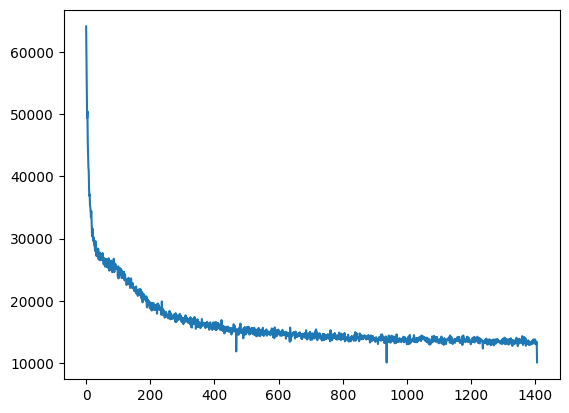

In [13]:
optimizer = Adam(vae.parameters(),lr=1e-3,weight_decay=1e-5)
losses = []
for epoch in range(3):
    for im_batch, _ in tqdm(train_loader):
        im_batch = im_batch.to(device)      
        optimizer.zero_grad()
        reconstruction, mean, logvar = vae(im_batch, return_dist=True) 
        # Loss:
        reconstruction_loss = F.binary_cross_entropy(reconstruction, im_batch, reduction='sum')
        kl_div_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
        loss = reconstruction_loss + kl_div_loss
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
plt.plot(losses)

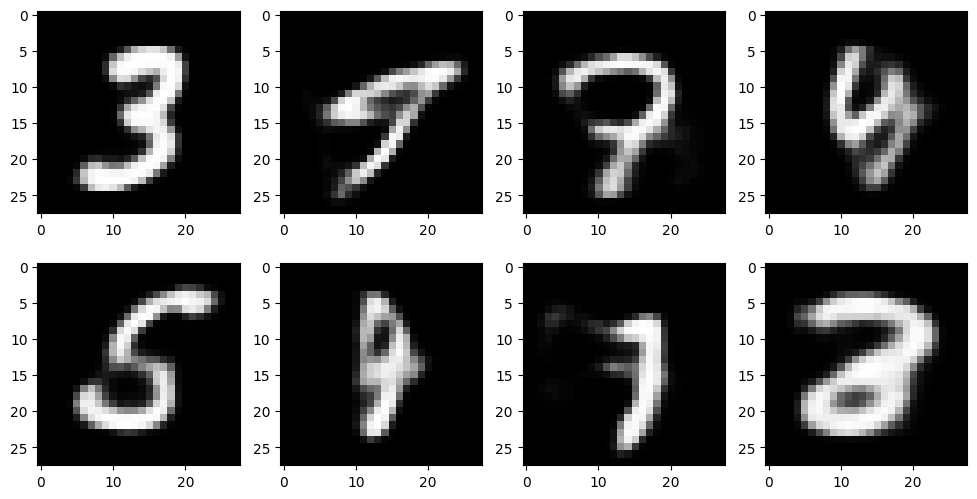

In [14]:
# Generate new images from random zs
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
for i in range(8):
    im = vae.decode(torch.randn(1, 20).to(device)) # Random point
    axs[i//4][i%4].imshow(im.detach().cpu().squeeze(), cmap='gray')

### 4. Define & Train VAE - Linear/Fully-connected 

In [15]:
class Encoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_mean = nn.Linear(hidden_dim, latent_dim)
        self.fc_var = nn.Linear (hidden_dim, latent_dim)        
        self.LeakyReLU = nn.LeakyReLU(0.2)        
        self.training = True
        
    def forward(self, x):
        h_ = self.LeakyReLU(self.fc1(x))
        h_ = self.LeakyReLU(self.fc2(h_))
        mean = self.fc_mean(h_)
        log_var = self.fc_var(h_)                     
        # encoder produces mean and log of variance 
        # (i.e., parateters of simple tractable normal distribution "q")
        return mean, log_var

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_out = nn.Linear(hidden_dim, output_dim)
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        h = self.LeakyReLU(self.fc1(x))
        h = self.LeakyReLU(self.fc2(h))
        x_hat = torch.sigmoid(self.fc_out(h))
        return x_hat

class FCVAE(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(FCVAE, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
        
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device) # sampling epsilon        
        z = mean + var*epsilon # reparameterization trick
        return z        
                
    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # 2nd term is just sqrt(var)
        x_hat = self.Decoder(z)
        return x_hat, mean, log_var

# Instantiate the model
encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim=hidden_dim, output_dim=x_dim)
fcvae = FCVAE(Encoder=encoder, Decoder=decoder)
fcvae = fcvae.to(device)

In [16]:
def loss_function(x, x_hat, mean, log_var):
    reconstruction_loss = F.binary_cross_entropy(x_hat, x, reduction='sum') # nn.BCELoss()
    kl_div_loss = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())
    return reconstruction_loss + kl_div_loss


In [17]:
fcvae.train()
optimizer = Adam(fcvae.parameters(), lr=lr)
epochs = 10
for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.view(x.shape[0], x_dim)
        x = x.to(device)
        optimizer.zero_grad()
        x_hat, mean, log_var = fcvae(x)
        loss = loss_function(x, x_hat, mean, log_var)        
        overall_loss += loss.item()        
        loss.backward()
        optimizer.step()        
    print(f"Epoch {epoch + 1}: Average Loss: {overall_loss / (batch_idx*batch_size)}")

Epoch 1: Average Loss: 177.05454992636655
Epoch 2: Average Loss: 130.85615723764795
Epoch 3: Average Loss: 117.87998241848416
Epoch 4: Average Loss: 113.4341502556434
Epoch 5: Average Loss: 110.70883569961939
Epoch 6: Average Loss: 108.5369211017576
Epoch 7: Average Loss: 107.31007866166595
Epoch 8: Average Loss: 106.4468316461286
Epoch 9: Average Loss: 105.76385498046875
Epoch 10: Average Loss: 105.09504923046144


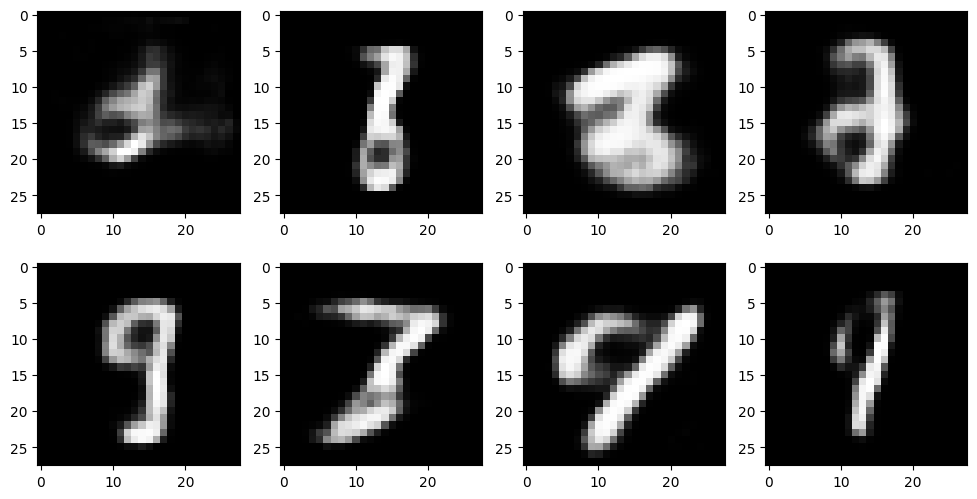

In [20]:
# Generate new images from random z
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
for i in range(8):
    im = decoder(torch.randn(1, latent_dim).to(device))
    #axs[i//4][i%4].imshow(im.detach().cpu().squeeze(), cmap='gray')
    axs[i//4][i%4].imshow(im.detach().cpu().view(28, 28), cmap='gray')

### References
1. https://github.com/Jackson-Kang/Pytorch-VAE-tutorial/blob/master/01_Variational_AutoEncoder.ipynb
2. https://www.coursera.org/specializations/generative-adversarial-networks-gans
3. https://johnowhitaker.github.io/tglcourse/generative_1.html
4. https://github.com/pytorch/examples/blob/main/vae/main.py
5. https://stackoverflow.com/questions/60533150/what-is-the-difference-between-sample-and-rsample/70818755#70818755
6. https://stackoverflow.com/questions/70163823/how-does-a-gradient-backpropagates-through-random-samples
7. https://discuss.pytorch.org/t/back-propagation-on-variable-sampled-by-random-distribution/31790
8. https://www.cs.toronto.edu/~rgrosse/courses/csc421_2019/slides/lec17.pdf
9. https://deepgenerativemodels.github.io/notes/vae/



